# Objective
My current goal is to optimize the layer thicknesses in SiN/SiO2 mirrors such that the stopband is as spectrally broad as possible at a given center wavelength


# Starting guess
I'll assume the center of the reflection band is 4500 nm (2222 cm$^{-1}$), so we will start with quarter wave stacks.  

We will base the guess thicknesses on using SiO2 ($n \approx 1.5$) and Si3N4 ($n \approx 2.04$) using
$$ nd=\frac{\lambda}{4} \rightarrow d = \frac{\lambda}{4n}$$

with $\lambda = 4500 n m$.

In [1]:
import wptherml
from matplotlib import pyplot as plt
import numpy as np
import time


In [2]:
# guess thickness for glass
d1 = 4500e-9 / (4 * 1.5)
# guess thickness for Si3N4
d2 = 4500e-9 / (4 * 2.04)

print(F"Trial thickness of glass layer is {d1:.3e} m")
print(F"Trial thickness of alumina layer is {d2:.3e} m")

Trial thickness of glass layer is 7.500e-07 m
Trial thickness of alumina layer is 5.515e-07 m


# Structure specification
We will set up a structure with 13 periods of alternating SiO2 and Al2O3 (26 layers total).
To use the universal dispersion models for SiO2 and Al2O3, we will use the material keywords
"SiO2_UDM" and "Al2O3_UDM".

The spectra will be computed in the wavelength range $300 \: nm - 6000 \: nm$.  This wavelength range of the spectra and integral are set by the `wavelength_list` keywords.

The structure composition is set by the `Material_List` keyword; you can subsitute any of the
central layers by changing the chemical formula.  The materials you listed (Ag, Si3N4, SiO2, TiO2, Al2O3, Ta2O5, ZrO2) are all supported and can be specified by those strings in the Material_List.  The terminal layers (first and last) should remain "Air" and their thickness should be fixed at 0 for all calculation.

The structure geometry is set by the `Thickness_List` keyword.


# Objective functions
We will set the desired window of high reflectivity to be between $2000 \: cm^{-1} - 2400 \: cm^{-1}$
(equivalently, $4166 \: nm - 5000 \: nm$.)

We will compute three different figures of merit that we will call the transmission efficiency ($\eta_T$),
reflection efficiency ($\eta_R$), and reflection selectivity ($\eta_{RS}$).  You can adjust the relative importance of these in your optimization using keys "transmission_efficiency_weight", "reflection_efficiency_weight", and "reflection_selectivity_weight".  The default is to give them equal weighting.

We will define the transmission efficiency as

$$ \eta_T = \frac{\int_{\lambda_1}^{\lambda_2} \Pi_T(\lambda) T(\lambda) d\lambda }{\int_{\lambda_1}^{\lambda_2} \Pi_T(\lambda) d\lambda} $$
where $T(\lambda)$ is the transmission spectrum of the stack and $\Pi_T(\lambda)$ is the desired
transmission envelope (defined to be 1 in the range specified by the `transmissive_window_nm` keyword and 0 elsewhere; note the user specifies this in units of nanometers.  The default is 350 - 700 nm).

The reflection efficiency can be defined as
$$ \eta_R = \frac{\int_{\lambda_1}^{\lambda_2} \Pi_R(\lambda) R(\lambda) d\lambda }{\int_{\lambda_1}^{\lambda_2} R(\lambda) d\lambda} $$
where $R(\lambda)$ is the reflection spectrum of the stack and $\Pi_R(\lambda)$ is the desired
reflection envelope (defined to be 1 in the range specified by the `reflective_window_wn` keyword and 0 elsewhere,
note the user specifies this in units of inverse centimeters.  The default is 2000 - 2400 $cm^{-1}$).


The reflection selectivity can be defined as
$$ \eta_{RS} = \frac{\int_{\lambda_1}^{\lambda_2} \Pi_R(\lambda) R(\lambda) d\lambda }{\int_{\lambda_1}^{\lambda_2} \Pi_R(\lambda) d\lambda} $$
where $R(\lambda)$ is the reflection spectrum of the stack and $\Pi_R(\lambda)$ is the desired
reflection envelope (defined to be 1 in the range specified by the `reflective_window_wn` keyword and 0 elsewhere,
note the user specifies this in units of inverse centimeters.  The default is 2000 - 2400 $cm^{-1}$).

The block below will create an instance of a DBR that we will call `test`.  

We will call the method `test.compute_selective_mirror_fom()` to compute $\eta_T$, $\eta_R$, and $\eta_{RS}$ as well as a
composite figure of merit called `test.selective_mirror_fom` defined as $f =  \alpha \cdot \eta_T + \beta \cdot \eta_R + \gamma \cdot \eta_{RS}$
where $\alpha$ is set by the keyword "transmission_efficiency_weight", $\beta$ is set
by the keyword "reflection_efficiency_weight", and $\gamma$ is set by the keyword "reflection_selectivity_weight".  These values will be normalized
automatically so that $\alpha + \beta + \gamma = 1$.

# Gradients
We can compute gradients of the objectives, which are vectors with the length of
the number of layers.  Take for example the gradient for the transmission efficiency, ${\bf g}$, which
has elements defined as
\begin{equation}
g_i = \frac{\partial \eta_T}{\partial d_i}
\end{equation}
where $d_i$ is the thickness of layer $i$.  We can compute these gradients by calling `test.compute_selective_mirror_fom_gradient()`, and the gradients will be stored as follows:

- Transmission efficiency gradient: `test.transmission_efficiency_gradient`
- Reflection efficiency gradient: `test.reflection_efficiency_gradient`
- Reflection selectivity gradient: `test.reflection_selectivity_gradient`
- Selective mirror figure of merit gradient: `test.selective_mirror_fom_gradient`

Where again we will use the weights defined by $\alpha$, $\beta$ and $\gamma$ that are specified by the user (and default to 1/3 for each).

The block below will create a dielectric mirror with 18 layers (9 repeats of SiO2/Si3N4) using the guess thicknesses from above, compute the 
figures of merit, the gradient of these figures of merit, and plot the reflectance spectra against the desired window in wavelength (converted in plot from meters to nm) and wavenumber (converted in plot from inverse meters to inverse centimeters).

Found transmission efficiency weight (TEW) arg
TEW is 0.0
Found reflection efficiency weight (REW) arg
REW is 0.5
Found reflection selectivity weight (RSW) arg
RSW is 0.5
1.0
 Your spectra have been computed! 😎 


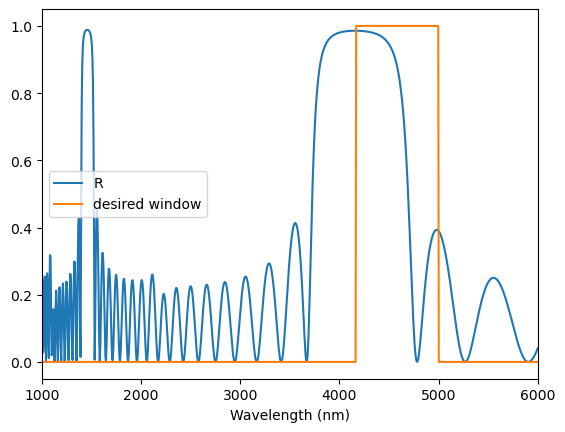

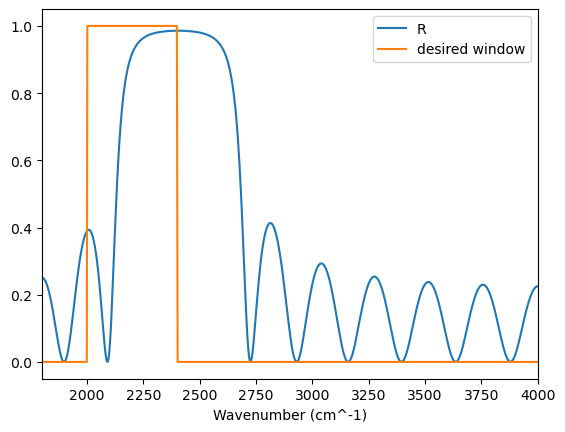

Reflection Efficiency is 30.62 %
Reflection Selectivity is 66.63 %
Transmission Efficiency is 70.88 %
Composite FOM is 48.63 %


In [3]:

test_args = {
    "wavelength_list": [300e-9, 6000e-9, 1000],
    "Material_List": ["Air",
                      "SiO2", "Si3N4", "SiO2", "Si3N4","SiO2", "Si3N4",
                      "SiO2", "Si3N4","SiO2", "Si3N4","SiO2", "Si3N4",
                      "SiO2", "Si3N4","SiO2", "Si3N4","SiO2", "Si3N4",
                      "Air"],
    "Thickness_List": [0,
                       d1, d2, d1, d2, d1, d2,
                       d1, d2, d1, d2, d1, d2,
                       d1, d2, d1, d2, d1, d2,
                       0],
    "reflective_window_wn" : [2000, 2400],
    "transmissive_window_nm" : [350, 700],
    "transmission_efficiency_weight" : 0.0,
    "reflection_efficiency_weight" : 0.5,
    "reflection_selectivity_weight" : 0.5,
 }

sf = wptherml.SpectrumFactory()


# create an instance of the DBR called test
test = sf.spectrum_factory('Tmm', test_args)

# plot of reflectivity vs wavelength in meters
plt.plot(test.wavelength_array * 1e9, test.reflectivity_array, label="R")
plt.plot(test.wavelength_array * 1e9, test.reflective_envelope, label="desired window")
plt.xlim(1000, 6000)
plt.xlabel("Wavelength (nm)")
plt.legend()
plt.show()

# plot of reflectivity vs wavenumber in cm^-1
plt.plot(test.wavenumber_array * 1e-2, test.reflectivity_array, label="R")
plt.plot(test.wavenumber_array * 1e-2, test.reflective_envelope, label="desired window")
plt.xlim(1800, 4000)
plt.xlabel("Wavenumber (cm^-1)")
plt.legend()
plt.show()

# compute the foms
test.compute_selective_mirror_fom()

# compute the gradient of the foms - this is slower than computing the FOM itself
test.compute_selective_mirror_fom_gradient()

print(F'Reflection Efficiency is {100 * test.reflection_efficiency:.2f} %')
print(F'Reflection Selectivity is {100 * test.reflection_selectivity:.2f} %')
print(F'Transmission Efficiency is {100 * test.transmission_efficiency:.2f} %')
print(F'Composite FOM is {100 * test.selective_mirror_fom:.2f} %')





Now we will set up an optimization.  We will create an instances of the OptDriver class and then call one of it's optimization methods.

For local optimizations, call the `optimize_bfgs` method.  These are typically fairly short calculations, of course it will depend on the number of layers you want to optimize, but ~20 layers will take a few minutes.

To attempt a global optimization, call the `optimize_basin_hopping` method.  This will run many local optimizations with some random perturbations to the geometry in between each one, these can take many hours to days depending on the number of layers and the options.


In [4]:
# create an instance of the OptDriver class called opt_test
opt_test = sf.spectrum_factory("Opt", test_args)

# run the optimize_bfgs method - results will be captured in opt_results, but they will 
# also be accessible as attributes of the instance opt_test.
opt_results = opt_test.optimize_bfgs()

# global optimziation can be run with the optimize_basin_hopping method
# this can take much longer, uncomment and run if you have time to wait!
#opt_results = opt_test.optimize_basin_hopping()

Found transmission efficiency weight (TEW) arg
TEW is 0.0
Found reflection efficiency weight (REW) arg
REW is 0.5
Found reflection selectivity weight (RSW) arg
RSW is 0.5
1.0
 Computing figure of merit and graident from thickness array  [750.         551.47058824 750.         551.47058824 750.
 551.47058824 750.         551.47058824 750.         551.47058824
 750.         551.47058824 750.         551.47058824 750.
 551.47058824 750.         551.47058824]
 Current FOM is -0.4862580148492881
 Current Gradient is [ 1.12769544e-04 -1.17570148e-06 -8.44733884e-05 -1.78197238e-04
 -1.90432382e-04 -2.75968928e-04 -2.02445568e-04 -2.39063220e-04
 -1.53339049e-04 -1.43643072e-04 -1.22025612e-04 -1.55616494e-04
 -1.62896676e-04 -2.40876252e-04 -2.11866245e-04 -2.59185484e-04
 -1.73641744e-04 -1.84896180e-04]
 Initial FOM is -0.4862580148492881
 Initial Gradient is [ 1.12769544e-04 -1.17570148e-06 -8.44733884e-05 -1.78197238e-04
 -1.90432382e-04 -2.75968928e-04 -2.02445568e-04 -2.39063220e-04
 -

Now we can look at the original spectra associated with the instance `test` and the optimized spectra associated with `opt_test`.  We can also print the updated list of thicknesses and their associated materials (the materials are fixed, only the thicknesses change).

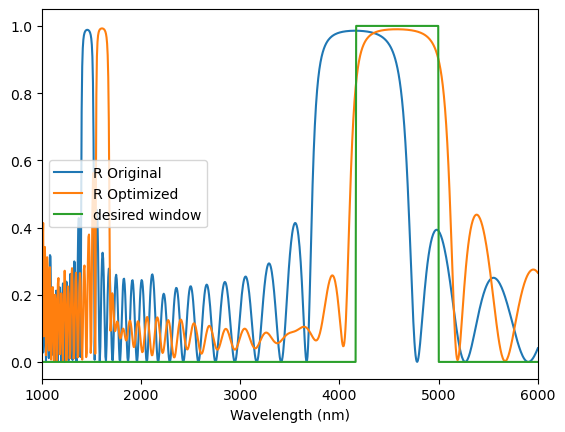

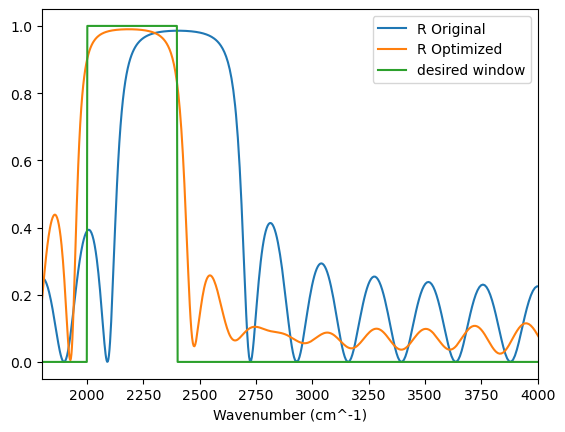

List of materials by layer (incident side first)
['Air', 'SiO2', 'Si3N4', 'SiO2', 'Si3N4', 'SiO2', 'Si3N4', 'SiO2', 'Si3N4', 'SiO2', 'Si3N4', 'SiO2', 'Si3N4', 'SiO2', 'Si3N4', 'SiO2', 'Si3N4', 'SiO2', 'Si3N4', 'Air']
Original list of layer thicknesses (incident side first)
[0.00000000e+00 7.50000000e-07 5.51470588e-07 7.50000000e-07
 5.51470588e-07 7.50000000e-07 5.51470588e-07 7.50000000e-07
 5.51470588e-07 7.50000000e-07 5.51470588e-07 7.50000000e-07
 5.51470588e-07 7.50000000e-07 5.51470588e-07 7.50000000e-07
 5.51470588e-07 7.50000000e-07 5.51470588e-07 0.00000000e+00]
Optimized list of layer thicknesses (incident side first)
[0.00000000e+00 4.34195096e-07 5.94041999e-07 8.46257474e-07
 6.00249233e-07 8.31586246e-07 6.06122196e-07 8.39256787e-07
 6.02435030e-07 8.50574861e-07 6.00054355e-07 8.43002839e-07
 6.01070192e-07 8.42349275e-07 6.07620982e-07 8.38333226e-07
 6.02818091e-07 8.33384581e-07 6.08850505e-07 0.00000000e+00]


In [5]:
plt.plot(test.wavelength_array * 1e9, test.reflectivity_array, label="R Original")
plt.plot(opt_test.wavelength_array * 1e9, opt_test.reflectivity_array, label="R Optimized")
plt.plot(test.wavelength_array * 1e9, test.reflective_envelope, label="desired window")
plt.xlim(1000, 6000)
plt.xlabel("Wavelength (nm)")
plt.legend()
plt.show()

# plot of reflectivity vs wavenumber in cm^-1
plt.plot(test.wavenumber_array * 1e-2, test.reflectivity_array, label="R Original")
plt.plot(opt_test.wavenumber_array * 1e-2, opt_test.reflectivity_array, label="R Optimized")
plt.plot(test.wavenumber_array * 1e-2, test.reflective_envelope, label="desired window")
plt.xlim(1800, 4000)
plt.xlabel("Wavenumber (cm^-1)")
plt.legend()
plt.show()

print("List of materials by layer (incident side first)")
print(test.material_array)
print("Original list of layer thicknesses (incident side first)")
print(test.thickness_array)
print("Optimized list of layer thicknesses (incident side first)")
print(opt_test.thickness_array)

Plots of reflectance, transmittance, and absorbance just for fun!

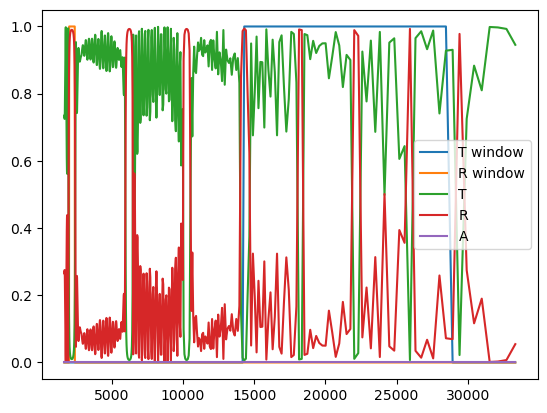

In [6]:

plt.plot(opt_test.wavenumber_array * 1e-2, opt_test.transmissive_envelope, label='T window')
plt.plot(opt_test.wavenumber_array * 1e-2, opt_test.reflective_envelope, label='R window')
plt.plot(opt_test.wavenumber_array * 1e-2, opt_test.transmissivity_array, label='T')
plt.plot(opt_test.wavenumber_array * 1e-2, opt_test.reflectivity_array, label='R')
plt.plot(opt_test.wavenumber_array * 1e-2, opt_test.emissivity_array, label='A')
plt.legend()

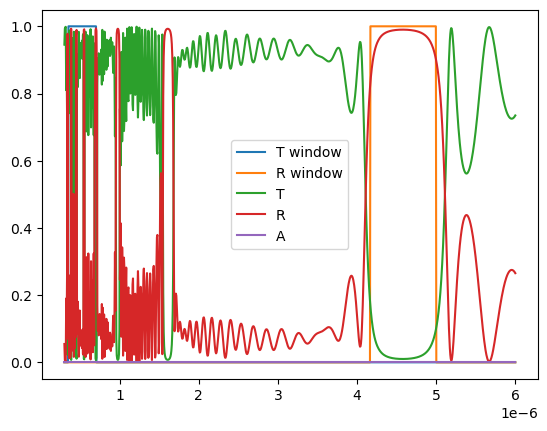

In [7]:
plt.plot(opt_test.wavelength_array, opt_test.transmissive_envelope, label='T window')
plt.plot(opt_test.wavelength_array, opt_test.reflective_envelope, label='R window')
plt.plot(opt_test.wavelength_array, opt_test.transmissivity_array, label='T')
plt.plot(opt_test.wavelength_array, opt_test.reflectivity_array, label='R')
plt.plot(opt_test.wavelength_array, opt_test.emissivity_array, label='A')
plt.legend()

